In [2]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from src.equations import *

In [3]:
def plot_equation_3d(samples: np.array, fitnesses: np.array, s: int = 5, alpha: float = 0.6):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(samples[:, 0], samples[:, 1], fitnesses, c=fitnesses, cmap='viridis', s=s, alpha=alpha)

    ax.set_xlabel('x₀')
    ax.set_ylabel('x₁')
    ax.set_zlabel('f(x)')
    fig.colorbar(sc, ax=ax, label='f(x) latin hypercube')

    plt.title(f'Best sample fitness: {np.min(fitnesses)}')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

def schwefel(x):
    """
    Función de Schwefel vectorizada.
    
    Parámetros:
    -----------
    x : array-like
        Punto(s) donde evaluar la función
    
    Retorna:
    --------
    float o array
        Valor(es) de la función Schwefel
        
    Mínimo global: f(420.9687) ≈ 0
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    n = x.shape[1]
    term = x * np.sin(np.sqrt(np.abs(x)))
    total = np.sum(term, axis=1)
    result = 418.9829 * n - total
    return result[0] if result.shape[0] == 1 else result


def gradiente_numerico(f, x, h=1e-6): # ∇f
    x = np.asarray(x, dtype=float)
    grad = np.zeros_like(x)
    for i in range(len(x)):
        xp, xm = x.copy(), x.copy()
        xp[i] += h; xm[i] -= h
        grad[i] = (f(xp) - f(xm)) / (2*h)
    return grad

def hessiana_numerica(f, x, h=1e-4): # ∇²f
    x = np.asarray(x, dtype=float)
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            x_pp = x.copy(); x_pm = x.copy()
            x_mp = x.copy(); x_mm = x.copy()
            x_pp[i] += h; x_pp[j] += h
            x_pm[i] += h; x_pm[j] -= h
            x_mp[i] -= h; x_mp[j] += h
            x_mm[i] -= h; x_mm[j] -= h
            Hij = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4*h*h)
            H[i, j] = Hij
            H[j, i] = Hij  # uso simetría
    return H

def newton_minimizar(f, x0, tol=1e-8, max_iter=50, damping=1e-6):
    x = np.asarray(x0, dtype=float)
    if x.ndim != 1:
        raise ValueError("x0 debe ser un array 1D")
    grad_norms = []
    
    for k in range(max_iter):
        g = gradiente_numerico(f, x)
        norm_g = np.linalg.norm(g)
        grad_norms.append(norm_g)
        if norm_g < tol:
            print(f"✅ Convergido en {k} iteraciones (||grad||={norm_g:.2e}).")
            return x, grad_norms
        
        H = hessiana_numerica(f, x)
        # Regularizar si está cerca de singular
        H += np.eye(len(x)) * damping
        
        # Comprobar simetría
        if not np.allclose(H, H.T, atol=1e-8):
            raise RuntimeError(f"Hessiana no simétrica en iteración {k}")
        
        try:
            delta = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            raise RuntimeError(f"Hessiana singular en iteración {k}")
        
        x = x + delta
    
    print(f"No convergió en {max_iter} iteraciones (||grad||={norm_g:.2e}).")
    return x, grad_norms
    #raise RuntimeError(f"No convergió en {max_iter} iteraciones (||grad||={norm_g:.2e}).")

# --- Ejemplo de uso ---
if __name__ == "__main__":
    x0 = np.array([-410.0, 400.0, 39.0])
    print(schwefel(x0))
    x_min, grad_hist = newton_minimizar(schwefel, x0, max_iter=2000)
    print("Mínimo aproximado en:", x_min)
    print("Valor de Schwefel:", schwefel(x_min))
    print("Última norma del gradiente:", grad_hist[-1])


1297.2170892883591
✅ Convergido en 6 iteraciones (||grad||=7.39e-11).
Mínimo aproximado en: [-420.96874444  420.96874444   65.54785451]
Valor de Schwefel: 1193.3137180484603
Última norma del gradiente: 7.389644451905042e-11


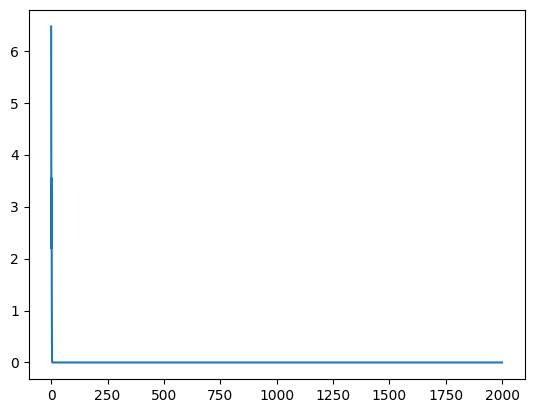

In [68]:
plt.plot(grad_hist)